# Script to match the relevant tables for 4Hi-q

## Requirements

To be able to run this, the following requirements need to be met:

- A `python 3.10` environment, including the `astropy`, `astroquery` and standard modules
- The `function package` and the `catalogues` in the same directory.

## Structure

This script consists of a few separate parts to handle the catalogue data, divided into the following sections:

- Querying for the catalogue data and writing backups to disk, requiring the following:
  - A `region` specified in the beginning, used for RA and DEC constraints
  - An `agn_cat`, providing RA, DEC and probability information on the AGNs
  - The `sweep_cat` catalogues for the region in question (TODO: Use the LS DR query interface)
  - The `vhs_cat` is obtained by querying the Vista Science Archive
- Matching the catalogues, also writing a backup.
  - The matching is performed on the respective RA and DEC coordinates (TODO: Use the advanced constraints described in my thesis)
  - A match via the `cds` service is performed with the GALEX catalogue
- Processing the catalogues (unit conversions and reddening correction), including a split into *pointlike* and *extended*.
- Collapsing everything into a `LePhare` input file
- Running `LePhare`:
  - Collect the filter information
  - Collect the template information
  - Run the photo-z-routine

All of the functions used for these routines can either be found directly in this notebook or in the `function_package` directory.

In [17]:
import function_package as fp
import logging
logging.getLogger().setLevel("INFO")

logging.info("Modules loaded successfully")

INFO:root:Modules loaded successfully


In [18]:
# Define the region to constrain everything to:
# The eFEDs field is dec < 6.2 & dec > -3.2 & ra < 146.2 & ra > 126.
ra_min, ra_max, dec_min, dec_max = 125, 130, -5, 0
REGION = fp.Region(ra_min, ra_max, dec_min, dec_max)
logging.info(REGION)

INFO:root:Region constrained to 125.0000 <= RA <= 130.0000 and -5.0000 <= DEC <= 0.0000.
This corresponds to a linear (!) size of 25 deg^2


## Loading the tables

In this section, the tables are loaded.\
TODO: Make use of astroquery if possible

In [21]:
SHU_TABLE = fp.load_and_clean_opt_agn_shu(REGION)

INFO:root:The reduced shu_agn table provided contains 2437 sources.
INFO:root:After the probability cut at p_rf >= 0.940, 1899 sources are left in the shu_agn table


In [15]:
VHS_TABLE = fp.load_and_clean_vhs(REGION)

INFO:root:The vhs table provided contains 1547498 sources.
INFO:root:The reduced vhs table provided contains 291905 sources.


In [16]:
SWEEP_TABLE = fp.load_and_clean_sweep(REGION)

INFO:root:The following bricks are in the requested region for the sweep table:
['120m005-130p000']
INFO:root:The reduced sweep table provided contains 2421599 sources.


## Matching

Now that the tables are properly loaded (except for GALEX, which we'll acquire while matching), we can match them one by one.\
TODO: Implement the functions if possible

In [24]:
# MATCH_TABLE = fp.match_with_sweep(SHU_TABLE, SWEEP_TABLE)
# # TODO: Implement matching.
# MATCH_TABLE = fp.match_with_vhs(MATCH_TABLE, VHS_TABLE)
# MATCH_TABLE = fp.match_with_galex(MATCH_TABLE)

## Processing

The matched table can now be processed.\
For this, all columns are turned into corrected magnitude ones, and the table is split up into a *pointlike* and an *extended* part.

In [108]:
from astropy.table import Table, join
import warnings
from astropy.units import UnitsWarning
from function_package.load_and_clean_tables import _sanitise_table
import numpy as np

with warnings.catch_warnings():
    warnings.simplefilter("ignore", UnitsWarning)
    MATCH_TABLE = Table.read(f"{fp.DATAPATH}match_backups/baseline_input_raw_match.fits")
MATCH_TABLE = _sanitise_table(MATCH_TABLE, REGION, "matched")
MATCH_TABLE.rename_column("type", "sweep_type")
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UnitsWarning)
    POINTLIKE_COMP = Table.read(f"{fp.DATAPATH}match_backups/baseline_input_pointlike_processed.fits")
POINTLIKE_COMP = _sanitise_table(POINTLIKE_COMP, REGION, "matched")

INFO:root:The reduced matched table provided contains 975 sources.
INFO:root:The reduced matched table provided contains 903 sources.


In [116]:
# Test the performance of the new sweep processing:
SWEEP_CORR = fp.process_sweep_columns(MATCH_TABLE)
plike, ext = fp.split_table_by_sourcetype(SWEEP_CORR)
band = "g"
from function_package.custom_constants import ALL_SWEEP_BANDS
for band in ALL_SWEEP_BANDS:
    print(band)
    print(np.max((plike[f"c_flux_{band}"] - POINTLIKE_COMP[f"c_flux_{band}"])/ plike[f"c_flux_{band}"]))
logging.info("As we can see, the relative errors are neglectible.")

INFO:root:As we can see, the relative errors are neglectible.


g
1.1616040043749564e-07
r
1.0551129522971926e-07
z
1.0810402448477127e-07
w1
1.0754281431780065e-07
w2
1.0678235412312255e-07
w3
1.0759226515561465e-07
w4
1.0884313731172959e-07


In [115]:
# Test the performance of the new Galex processing
try:
    MATCH_TABLE.rename_columns(["fflux", "nflux", "e_fflux", "e_nflux"], ["flux_fuv", "flux_nuv", "flux_err_fuv", "flux_err_nuv"])
    MATCH_TABLE.rename_column("ebv_galex", "galex_ebv")
except KeyError:
    pass
GALEX_CORR = fp.process_galex_columns(MATCH_TABLE)
plike, ext = fp.split_table_by_sourcetype(GALEX_CORR)
from function_package.custom_constants import ALL_GALEX_BANDS
for band in ALL_GALEX_BANDS:
    mask = POINTLIKE_COMP[f"c_flux_{band}"] > 0
    print(band)
    print(np.max((plike[mask][f"c_flux_{band}"] - POINTLIKE_COMP[mask][f"c_flux_{band}"])/ plike[mask][f"c_flux_{band}"]))
logging.info("As we can see, the relative errors are neglectible, but we need to watch out for NAN values")

INFO:root:As we can see, the relative errors are neglectible, but we need to watch out for NAN values


fuv
1.4809559830549247e-07
nuv
1.1365383890635863e-07


y
j
0.22599068751236384
h
ks
0.595679725938292


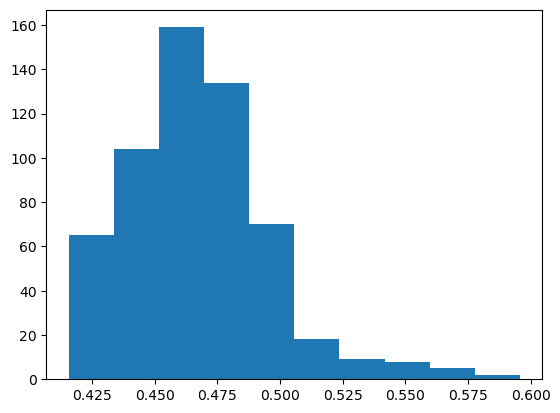

In [114]:
plike, ext = fp.split_table_by_sourcetype(MATCH_TABLE)
VHS_PLIKE = fp.process_vhs_columns(plike)
from function_package.custom_constants import ALL_VHS_BANDS
for band in ALL_VHS_BANDS:
    mask = POINTLIKE_COMP[f"c_flux_{band}"] > 0
    print(band)
    if np.sum(mask) > 0:
        print(np.max((VHS_PLIKE[mask][f"c_flux_{band}"] - POINTLIKE_COMP[mask][f"c_flux_{band}"])/ VHS_PLIKE[mask][f"c_flux_{band}"]))
VHS_PLIKE["c_flux_ks"] - POINTLIKE_COMP["c_flux_ks"]

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist((VHS_PLIKE[mask][f"c_flux_{band}"] - POINTLIKE_COMP[mask][f"c_flux_{band}"])/ VHS_PLIKE[mask][f"c_flux_{band}"])
logging.warning("There seems to be something wrong during the correction processing!")

In [119]:
PROCESSED = fp.process_galex_columns(MATCH_TABLE)
PROCESSED = fp.process_sweep_columns(PROCESSED)
POINTLIKE, EXTENDED = fp.split_table_by_sourcetype(PROCESSED)
POINTLIKE = fp.process_vhs_columns(POINTLIKE)
EXTENDED = fp.process_vhs_columns(EXTENDED)

## Create LePhare input table

Now that we do have the pointlike and extended subsets, we can create the LePhare input table: